# **TP 1 - Machine Learning**

## **Student: Isadora Cardoso**

-----

The goal of this work is to evaluate a neural network in MNIST dataset. This dataset contains an input of 5.000 written digit of size 28 x 28 (784 pixels for image).


We have to change the following hyperparameters in order to compare the resulted neural networks:
- **Hidden layer**: 25, 50, and 100 units;
- **Optimizer**: Gradient Descent, Stochastic Gradient Descent, and Mini-Batch (of size 10 and 50);
- **Learning rate**: 0.5, 1, and 10.

We use cross entropy as the loss fuction and sigmoid as activation function for each layer.


The results will be calculated and compared in this notebook.

The test were made in a Linux-OS machine, Intel® Core™ i7-4790 CPU @ 3.60GHz × 8, and 16GB RAM memory.

###  Importing the necessary modules

First, we have to import the modules to run the neural network. To this, we use Keras library, a very friendly API to design machine learning algorithms. According to their site:

> Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. *Being able to go from idea to result with the least possible delay is key to doing good research.* ([Keras](https://keras.io/), 2015)

Here we use TensorFlow as backend.

We will need to cross-validate the data, so we use KFold from *sklearn* module.

To plot, we use *matplotlib* and *seaborn*.

We use *pandas* to import the dataset.

Out of curiosity, we want to measure the time needed to train and evaluate the model, so we import *time* to this.

And we use *numpy* to handle the vector dataset, as well as to determine the seed of this work. It is important that the work presented here can be replicated in other environments, i.e., to make a reproducible work.

In [1]:
# Import Keras to run the neural network
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD

# Import KFold from sklearn to cross-validate
from sklearn.model_selection import KFold

# Import matplotlib and seaborn to plot the images throughout this notebook
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# We need to determine a seed for reproducibility
import numpy as np
seed = 123
np.random.seed(seed)

# We use pandas to import the dataset
import pandas as pd

# We use time to measure time needed to train and test the model
import time

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Importing the dataset

In this dataset, we have 10 classes, each one representing a digit from 0 to 9.

The first column in the dataset is the label, indicating the digit which the pixels in the row corresponds.

In [2]:
# Import dataset
mnist_train = pd.read_csv('data_tp1', header = None)

# Read the dataset head to check if it is correctly imported
mnist_train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Plotting a histogram, we can see that we have well-balanced classes.

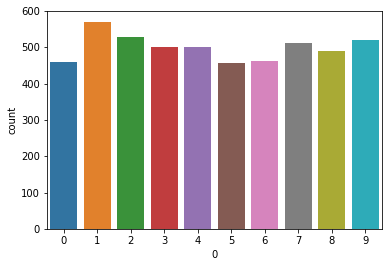

In [3]:
# Plot histogram
sns.countplot(mnist_train[0])

In [4]:
# Separate the dataset into pixel values (data) and labels (target digits)
data = (mnist_train.loc[:,1:].values).astype('float32')
labels = mnist_train.loc[:,0].values.astype('int32')

Out of curiosity, we can plot some examples of the data for visualization.

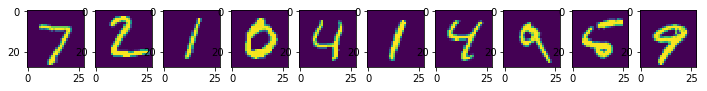

In [5]:
# Preview some images
plt.figure(figsize=(12,10))
total_images, size = 10, 4
for image in range(total_images):  
    plt.subplot(size, total_images, image+1)
    plt.imshow(data[image].reshape((28,28)),interpolation='nearest')
plt.show()

### Pre-processing data

We convert the labels, an one colunm matrix, to an one-hot encoding matrix, i.e, a vector with 10 colunms (the total of classes), filled with zero, except in the index that refers to the target digit, in which is one.

Example: 7 ---> [0,0,0,0,0,0,0,1,0,0]

This is the format most commonly used in the fitting and predicting of neural networks, adopted by Keras.


We also normalize the pixels from 0 to 255 (the range of the pixels values in a grey image) to a range from 0 to 1. It helps to fast training and reduces the chances of getting stuck in local optima.

In [6]:
# Convert labels to one-hot encoding
labels = keras.utils.to_categorical(labels)

# Normalize inputs from 0-255 to 0-1
data = data / 255
labels = labels / 255

### Creating the neural network model

Here we create a general neural network model. The model has three layers: 
- The first layer is the input layer. It has 784 units (the number of pixels in each image of size 28 x 28);
- The second layer is the hidden layer. We change the number of units to test the influence of this hyperparameter;
- The third layer is the output layer. It has 10 units (the number of classes).

We use 100 epochs.

We also need to change the optimizer algorithm to Gradient Descent, Stochastic Gradient Descent (SGD), and Mini-batch SGD. 
Using Keras, we can do this using the pre-built SGD algorithm, just changing the batch size in the following way:
- Gradient Descent: batch size is the number of training samples (use all examples in each iteration);
- Stochastic Gradient Descent (SGD): batch size is one (use only one example in each iteration);
- Mini-batch SGD: is the mentioned number, 10 and 50 (use the batch size training examples in each iteration).

We use some optimizations in the optimizer algorithm, momentum and nesterov, as described:

> **Momentum** is a method that helps accelerate SGD in the relevant direction and dampens oscillations. Essentially, when using momentum, we push a ball down a hill. The ball accumulates momentum as it rolls downhill, becoming faster and faster on the way (until it reaches its terminal velocity if there is air resistance). The same thing happens to our parameter updates: The momentum term increases for dimensions whose gradients point in the same directions and reduces updates for dimensions whose gradients change directions. As a result, we gain faster convergence and reduced oscillation. However, a ball that rolls down a hill, blindly following the slope, is highly unsatisfactory. We'd like to have a smarter ball, a ball that has a notion of where it is going so that it knows to slow down before the hill slopes up again. **Nesterov** accelerated gradient (NAG) is a way to give our momentum term this kind of prescience. ([RUDER, Sebastian. 2017](http://ruder.io/optimizing-gradient-descent/index.html#gradientdescentvariants))

We also use decay, which means that the learning rate is reduced in a fixed rate over time, thus quickly learning good weights early and fine tuning them after. It helps to avoid overfitting.


Furthermore, we determine the cross-validation split. To this, we decide to shuffle the input. Exemplifying, lets have an input [1,2,3,4,5,6,7,8,9,10]. So, splitting it into two parts, instead of getting the sequence [1,2,3,4,5] and [6,7,8,9,10], we can have shuffled vectors, such as [1,4,7,9,2]. It may help to reduce the bias of the data.

For each partition in cross-validation, we store its accuracy and loss for both training and test and present the mean of all partitions.

In [7]:
# Split into train and test to use k-cross-validation
k_split = 5
kfold = KFold(n_splits = k_split, shuffle = True, random_state = seed)

In [16]:
# Evaluate the model using cross-validation
def cv_neural_network(parameters):
    
    hidden_units, learning_rate, batches = parameters
    
    # Vectors to append the obtained values
    cv_val_loss = []
    cv_loss = []
    cv_val_acc = []
    cv_acc = []
    
    # Input dimension: 784 (total of pixels in an image, 28 x 28)
    input_dim = data.shape[1]
    
    # Total of classes: 10 (from 0 to 9)
    nb_classes = labels.shape[1]
    
    # Flag to print the cross-validation number
    cv = 1
    
    print("Starting evaluation at %s..." % (str(time.asctime(time.localtime(time.time())))))
    
    for train, test in kfold.split(data, labels):
        print("CV %d: started at %s, please wait..." % (cv, str(time.asctime( time.localtime(time.time()) ))))
        
        # Creating the model
        model = Sequential()
        model.add(Dense(input_dim, input_dim = input_dim, activation = 'sigmoid'))
        model.add(Dense(hidden_units, activation = 'sigmoid'))
        model.add(Dense(nb_classes, activation = 'sigmoid'))
        
        # Optimizer
        optimizer = SGD(lr = learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    
        # Compiling the model
        model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

        # Fitting the model
        history = model.fit(data[train], labels[train], validation_data = (data[test], labels[test]), 
                            epochs=100, verbose=0, batch_size = batches)
        
        cv_loss.append(np.mean(history.history['loss']))
        cv_val_loss.append(np.mean(history.history['val_loss']))
        cv_acc.append(np.mean(history.history['acc']))
        cv_val_acc.append(np.mean(history.history['val_acc']))
        
        cv += 1

    print("Finished at %s! Thank you for waiting." % (str(time.asctime( time.localtime(time.time()) ))))
    print("Accuracy: %.3f ---- Loss: %.3f ---- Validation accuracy: %.3f ---- Validation loss: %.3f" \
          % (np.mean(cv_acc), np.mean(cv_loss), np.mean(cv_val_acc), np.mean(cv_val_loss)))

#### Evaluating the hyperparameters

To evaluate all hyperparameters in a row, we build a list composed of all combination values (36 combinations) and we evaluate each combination, giving the metric values. 

We have several combinations and we need a huge amount of time to calculate them all - almost 24 hours. In addition, there is no thumb rule to chose the hyperparameters, so choose the others, such as epochs, decay, momentum, and nesterov are much more time consuming. Here we present the best evaluated configuration.

In [9]:
hidden_units = [25, 50, 100]
learning_rate = [0.5, 1, 10]
batches = [1, 10, 50, 4000]   

combinations = []

from itertools import product
for comb_parameters in product(hidden_units, learning_rate, batches):
    combinations.append(comb_parameters)

In [17]:
for hyperparameters in combinations:
    # Hyperparameters is composed of: hidden_units, learning_rate, and batch size (in this order)
    print ("Using as hyperparameters: %s" % str(hyperparameters))
    cv_neural_network(parameters)

Using as parameters: (25, 0.5, 1)
Starting evaluation at Thu May 17 13:16:44 2018...
CV 1: started at Thu May 17 13:16:44 2018, please wait...
CV 2: started at Thu May 17 13:39:12 2018, please wait...
CV 3: started at Thu May 17 14:01:04 2018, please wait...
CV 4: started at Thu May 17 14:23:20 2018, please wait...
CV 5: started at Thu May 17 14:45:58 2018, please wait...
Finished at Thu May 17 15:08:32 2018! Thank you for waiting.
Accuracy: 0.975 ---- Loss: 0.000 ---- Validation accuracy: 0.911 ---- Validation loss: 0.001
Using as parameters: (25, 0.5, 10)
Starting evaluation at Thu May 17 15:08:32 2018...
CV 1: started at Thu May 17 15:08:32 2018, please wait...
CV 2: started at Thu May 17 15:11:11 2018, please wait...
CV 3: started at Thu May 17 15:13:57 2018, please wait...
CV 4: started at Thu May 17 15:16:30 2018, please wait...
CV 5: started at Thu May 17 15:19:05 2018, please wait...
Finished at Thu May 17 15:21:38 2018! Thank you for waiting.
Accuracy: 0.874 ---- Loss: 0.002 -

The values obtained are as follows:


| Hidden units | Learning rate | Optimizer     | Accuracy | Loss   | Val. Accuracy | Val. Loss | Time      |
|--------------|---------------|---------------|----------|--------|---------------|-----------|-----------|
| **25**       | **0.5**       | **SGD**        | **97.5%**| **< 0.1%** | **91.1%** | **0.1%**  | **1h51m48s**  |
| 25           | 0.5           | 10-mini-batch | 87.4%    | 0.2%   | 84.8%         | 0.2%      | 13m06s    |
| 25           | 0.5           | 50-mini-batch | 68%      | 0.5%   | 67.5%         | 0.5%      | 03m21s    |
| 25           | 0.5           | GD           | 9.9%     | 0.9%   | 10.2%         | 0.9%      | 44s       |
| **25**       | **1**         | **SGD**        | **98.3%**| **< 0.1%** | **92.2%** | **0.1%**  | **1h54m28s**  |
| 25           | 1             | 10-mini-batch | 92.1%    | 0.1%   | 87.4%         | 0.2%      | 13m31s    |
| 25           | 1             | 50-mini-batch | 78.9%    | 0.3%   | 78%           | 0.3%      | 03m21s    |
| 25           | 1             | GD           | 9.8%     | 0.9%   | 9.8%          | 0.9%      | 45s       |
| 25           | 10            | SGD            | 76.1%    | 0.3%   | 73.6%         | 0.3%      | 1h59m13s  |
| **25**       | **10**        | **10-mini-batch** | **98.3%**  | **< 0.1%** | **92.1%**  | **0.1%** | **14m18s**  |
| 25           | 10            | 50-mini-batch | 95.2%    | 0.1%   | 89.1%         | 0.1%      | 03m35s    |
| 25           | 10            | GD           | 28.7%    | 0.9%   | 27.9%         | 0.9%      | 46s       |
| **50**       | **0.5**       | **SGD**        | **97.6%**| **< 0.1%** | **91.1%** | **0.1%**  | **2h04m59s**  |
| 50           | 0.5           | 10-mini-batch | 88.4%    | 0.2%   | 85.5%         | 0.2%      | 14m57s    |
| 50           | 0.5           | 50-mini-batch | 72.8%    | 0.4%   | 72.1%         | 0.4%      | 03m45s    |
| 50           | 0.5           | GD           | 10.2%    | 0.9%   | 9.9%          | 0.9%      | 49s       |
| **50**       | **1**         | **SGD**        | **98.3%**| **< 0.1%** | **92.1%** | **0.1%**  | **2h07m56s**  |
| 50           | 1             | 10-mini-batch | 92.7%    | 0.1%   | 88.1%         | 0.2%      | 15m18s    |
| 50           | 1             | 50-mini-batch | 80.8%    | 0.3%   | 79.7%         | 0.3%      | 03m51s    |
| 50           | 1             | GD           | 11%      | 0.9%   | 10.4%         | 0.9%      | 51s       |
| 50           | 10            | SGD            | 88%      | 0.2%   | 84%           | 0.3%      | 2h20m51s  |
| **50**       | **10**        | **10-mini-batch** | **98.4%**  | **< 0.1%** | **92.1%**  | **0.1%**   | **16m06s**  |
| 50           | 10            | 50-mini-batch | 95.7%    | 0.1%   | 89.6%         | 0.1%      | 03m57s    |
| 50           | 10            | GD           | 32.5%    | 0.9%   | 32.2%         | 0.9%      | 52s       |
| **100**      | **0.5**       | **SGD**        | **97.6%** | **< 0.1%** | **91%**  | **0.1%**  | **02h27m48s** |
| 100          | 0.5           | 10-mini-batch | 89%      | 0.1%   | 85.9%         | 0.2%      | 17m48s    |
| 100          | 0.5           | 50-mini-batch | 73.6%    | 0.4%   | 73.2%         | 0.4%      | 04m11s    |
| 100          | 0.5           | GD           | 10.7%    | 0.9%   | 11%           | 0.9%      | 56s       |
| **100**      | **1**         | **SGD**        | **98.3%**    | **< 0.1%** | **92%**  | **0.1%**   | **02h27m20s** |
| 100          | 1             | 10-mini-batch | 92.9%    | 0.1%   | 88%           | 0.2%      | 17m47s    |
| 100          | 1             | 50-mini-batch | 81.5%    | 0.3%   | 80.3%         | 0.3%      | 04m16s    |
| 100          | 1             | GD           | 11.6%    | 0.9%   | 11.2%         | 0.9%      | 58s       |
| **100**      | **10**        | **SGD**        | **98.3%** | **< 0.1%** | **92.3%**     | **0.1%**  | **02h37m1s**  |
| **100**      | **10**        | **10-mini-batch** | **98.3%**    | **< 0.1%** | **92.3%**  | **0.1%** | **18m0s**  |
| 100          | 10            | 50-mini-batch | 95.9%    | 0.1%   | 89.5%         | 0.2%      | 04m23s    |
| 100          | 10            | GD           | 35.8%    | 0.9%   | 35.4%         | 0.9%      | 01m00s    |

There are ten hypeparameters configuration in which we have an accuracy value, in both train and test, more than 90%. The loss are presented as 0%, but it is not true. It happens because the output is formated to 3 decimals. However, we can assure that the values are low, less than 0,1% (so we put this in the table).
We can see that SGD presents seven results among the ten best. However, mini-batch of size 10 presents results sightly superiors, needing much less time than SGD. We can see as well that the accuracy and loss values presented are very similar, hence, to use 10-mini-batch is a good way of optimizing. 

GD presents very low results, what may be underfitting.

#### Evaluating some results in detail

Here we plot some results presented in the previous section to evaluate they in more detail.

We create a plot function to plot the loss and accuracy to each cross-validation partition. The loss function is important so we can evaluate if the model is overfitting, underfitting, or being a good estimation to the function we want to predict.

We repeat the function to create the model adding the plot function and the epochs when inputting the hyperparameters, so we can change this value and evaluate how it influences the results. We also calculate the standard deviation to understand the data set variance.

Please note that the first five plots are for each partition in cross-validation and the last one refers to the average loss and accuracy to each fold.

In [18]:
def plot_loss(cv_acc, cv_val_acc, cv_loss, cv_val_loss):
    
    # Total of k-folds: 5
    folds = range(1,len(cv_loss)+1)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot accuracy mean
    ax[0].plot(folds, cv_acc)
    ax[0].plot(folds, cv_val_acc)
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('folds')
    ax[0].legend(['train', 'test'], loc='upper left')
    ax[0].grid()
    
    # Plot loss mean
    ax[1].plot(folds, cv_loss)
    ax[1].plot(folds, cv_val_loss)
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('folds')
    ax[1].legend(['train', 'test'], loc='upper left')
    ax[1].grid()

In [ ]:
# Split into train and test to use k-cross-validation
k_split = 5
kfold = KFold(n_splits = k_split, shuffle = True, random_state = seed)

# Evaluate the model using cross-validation
def cv_neural_network(parameters):
    
    hidden_units, learning_rate, batches, epochs = parameters
    
    # Vectors to append the obtained values
    cv_val_loss = []
    cv_loss = []
    cv_val_acc = []
    cv_acc = []
    
    # Input dimension: 784 (total of pixels in an image, 28 x 28)
    input_dim = data.shape[1]
    
    # Total of classes: 10 (from 0 to 9)
    nb_classes = labels.shape[1]
    
    # Flag to print the cross-validation number
    cv = 1
    
    print("Starting evaluation at %s..." % (str(time.asctime(time.localtime(time.time())))))
    
    for train, test in kfold.split(data, labels):
        print("CV %d: started at %s, please wait..." % (cv, str(time.asctime( time.localtime(time.time()) ))))
        
        # Creating the model
        model = Sequential()
        model.add(Dense(input_dim, input_dim = input_dim, activation = 'sigmoid'))
        model.add(Dense(hidden_units, activation = 'sigmoid'))
        model.add(Dense(nb_classes, activation = 'sigmoid'))
        
        # Optimizer
        optimizer = SGD(lr = learning_rate, decay=1e-6, momentum=0.9, nesterov=True)
    
        # Compiling the model
        model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

        # Fitting the model
        history = model.fit(data[train], labels[train], validation_data = (data[test], labels[test]), 
                            epochs=epochs, verbose=0, batch_size = batches)
        
        cv_loss.append(np.mean(history.history['loss']))
        cv_val_loss.append(np.mean(history.history['val_loss']))
        cv_acc.append(np.mean(history.history['acc']))
        cv_val_acc.append(np.mean(history.history['val_acc']))
        
        cv += 1
        
        plot_loss(history.history['acc'], history.history['val_acc'], 
                  history.history['loss'], history.history['val_loss'])

    
    print("Finished at %s! Thank you for waiting." % (str(time.asctime( time.localtime(time.time()) ))))
    print("Accuracy: %.5f (+/- %.5f)" % (np.mean(cv_acc), np.std(cv_acc)))
    print("Loss: %.5f (+/- %.5f)" % (np.mean(cv_loss), np.std((cv_loss))))
    print("Val Accuracy: %.5f (+/- %.5f)" % (np.mean(cv_val_acc), np.std((cv_val_acc))))
    print("Val Loss: %.5f (+/- %.5f)" % (np.mean(cv_val_loss), np.std((cv_val_loss))))

    plot_loss(cv_acc, cv_val_acc, cv_loss, cv_val_loss)

##### Best result
First we evaluate the best result.

With 200 epochs we can see some suggestion of overfitting, since the train loss is fixed, but test loss continues to increase.
On the other hand, with 10 epochs we can see signals of underfitting, since both training and test loss are decreasing.

We can see that the data set variance is low, not showing in 5 decimals.

Starting evaluation at Fri May 18 17:01:31 2018...
CV 1: started at Fri May 18 17:01:31 2018, please wait...
CV 2: started at Fri May 18 17:05:22 2018, please wait...
CV 3: started at Fri May 18 17:09:18 2018, please wait...
CV 4: started at Fri May 18 17:13:04 2018, please wait...
CV 5: started at Fri May 18 17:17:11 2018, please wait...
Finished at Fri May 18 17:21:00 2018! Thank you for waiting.
Accuracy: 0.98396 (+/- 0.00000)
Loss: 0.00020 (+/- 0.00000)
Val. accuracy: 0.92212 (+/- 0.00000)
Val. loss: 0.00125 (+/- 0.00000)


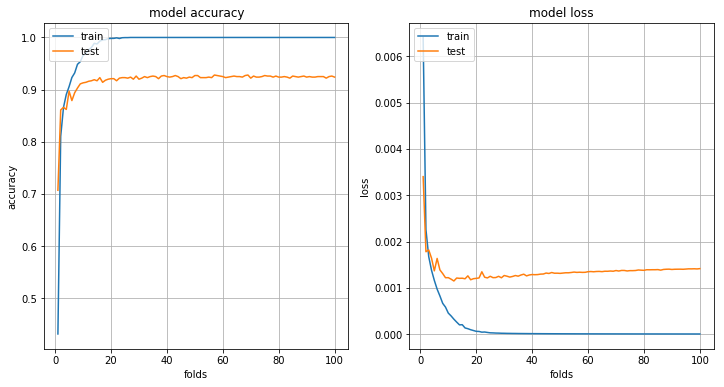

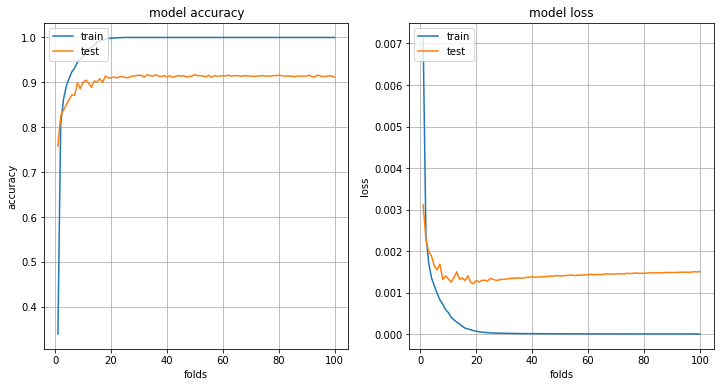

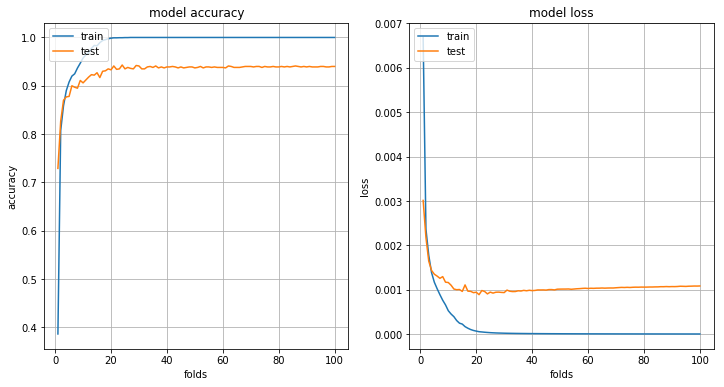

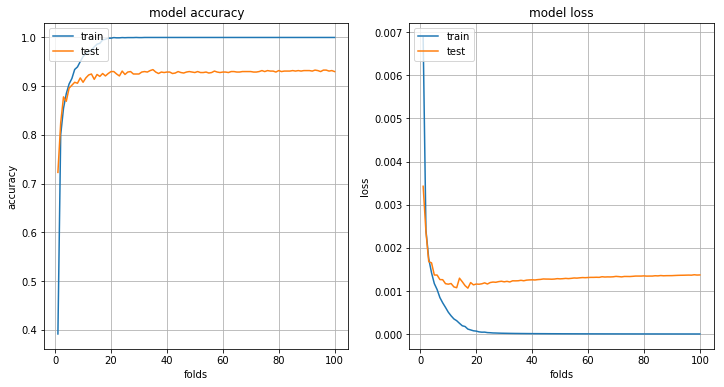

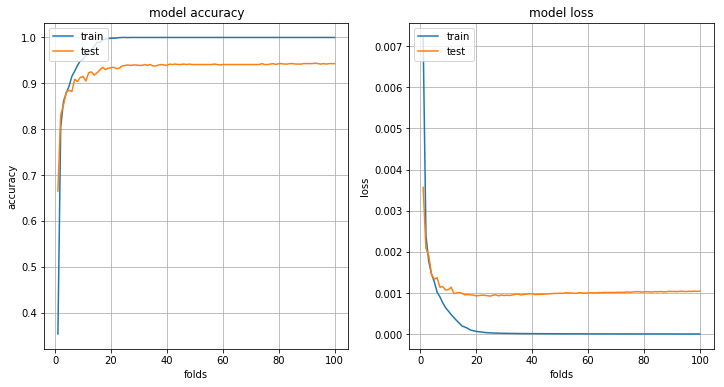

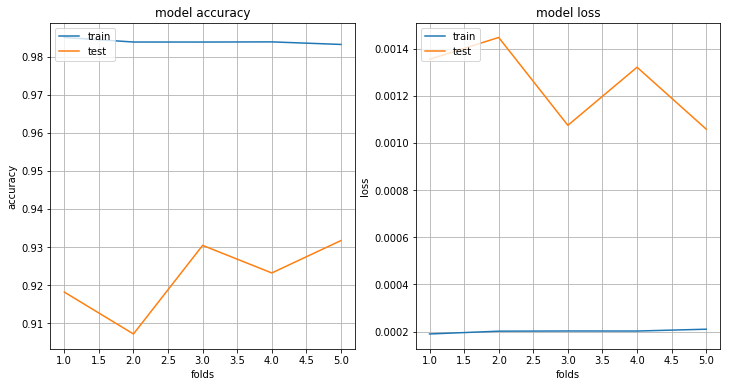

In [36]:
# Hyperparameters is composed of: hidden_units, learning_rate, batch size, and epochs (in this order)
hyperparameters = (50, 10, 10, 100)

cv_neural_network(hyperparameters)

Starting evaluation at Fri May 18 17:52:22 2018...
CV 1: started at Fri May 18 17:52:22 2018, please wait...
CV 2: started at Fri May 18 17:59:55 2018, please wait...
CV 3: started at Fri May 18 18:07:58 2018, please wait...
CV 4: started at Fri May 18 18:16:08 2018, please wait...
CV 5: started at Fri May 18 18:23:55 2018, please wait...
Finished at Fri May 18 18:31:43 2018! Thank you for waiting.
Accuracy: 0.99189 (+/- 0.00000)
Loss: 0.00010 (+/- 0.00000)
Val. accuracy: 0.92484 (+/- 0.00000)
Val. loss: 0.00131 (+/- 0.00000)


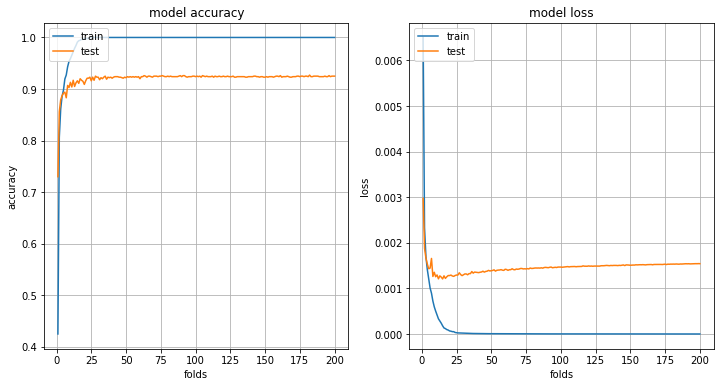

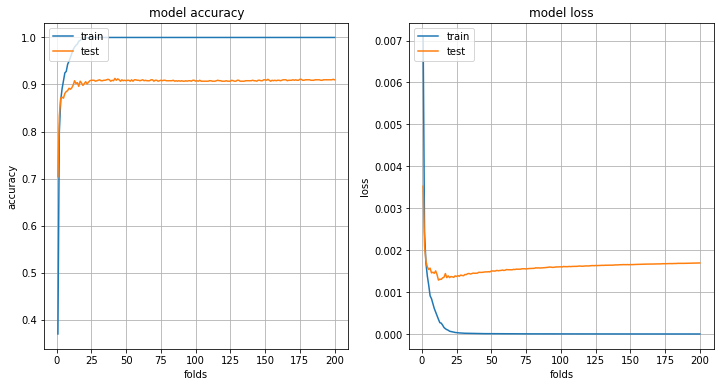

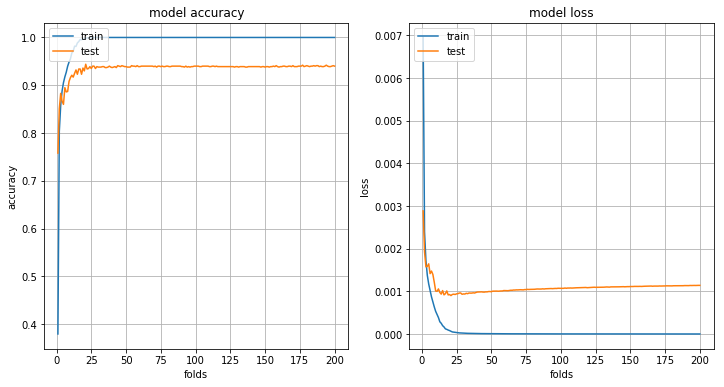

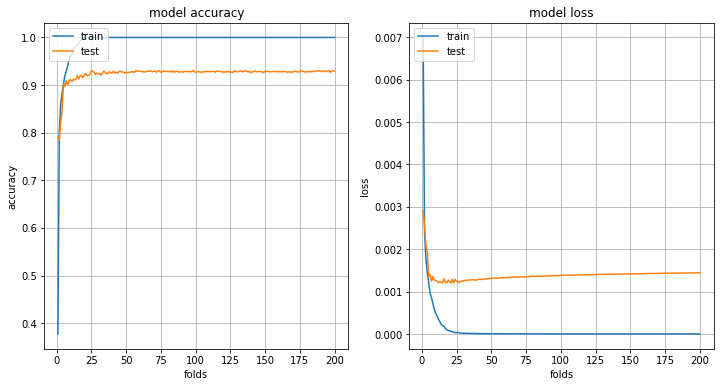

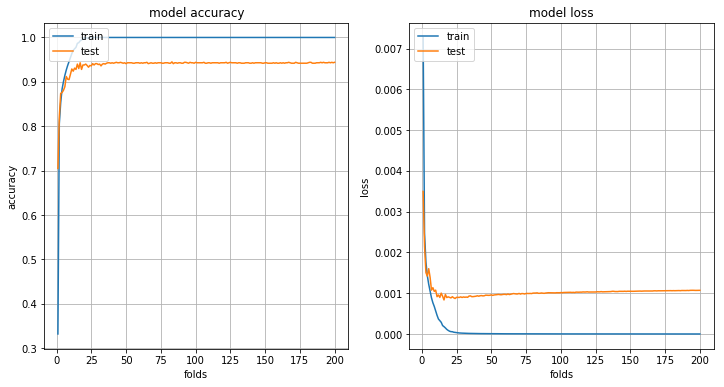

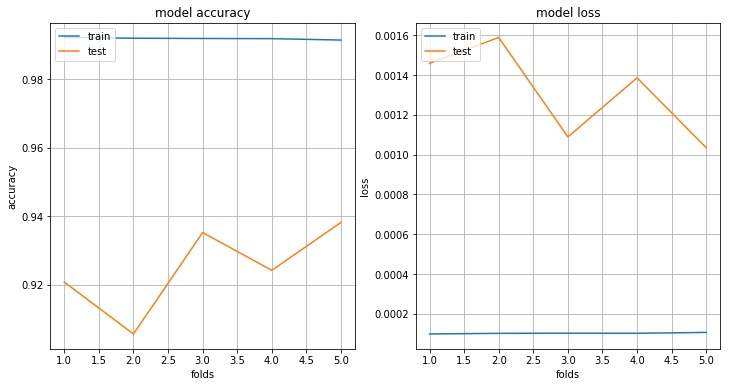

In [38]:
# Hyperparameters is composed of: hidden_units, learning_rate, batch size, and epochs (in this order)
hyperparameters = (50, 10, 10, 200)

cv_neural_network(hyperparameters)

Starting evaluation at Fri May 18 18:44:55 2018...
CV 1: started at Fri May 18 18:44:55 2018, please wait...
CV 2: started at Fri May 18 18:45:23 2018, please wait...
CV 3: started at Fri May 18 18:45:50 2018, please wait...
CV 4: started at Fri May 18 18:46:16 2018, please wait...
CV 5: started at Fri May 18 18:46:43 2018, please wait...
Finished at Fri May 18 18:47:10 2018! Thank you for waiting.
Accuracy: 0.85124 (+/- 0.00000)
Loss: 0.00175 (+/- 0.00000)
Val. accuracy: 0.86584 (+/- 0.00000)
Val. loss: 0.00168 (+/- 0.00000)


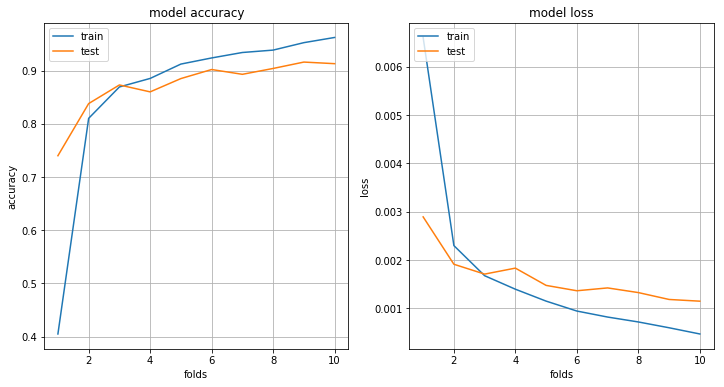

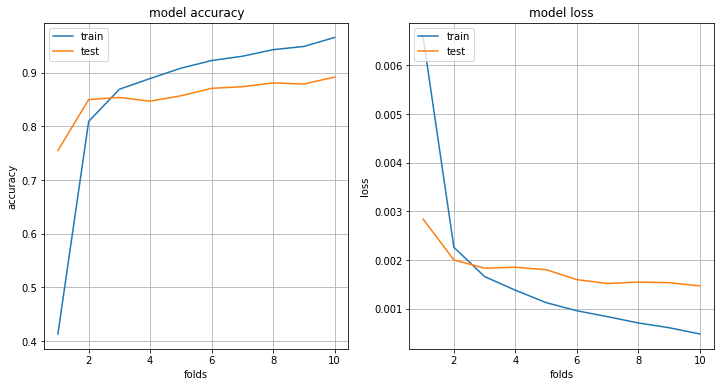

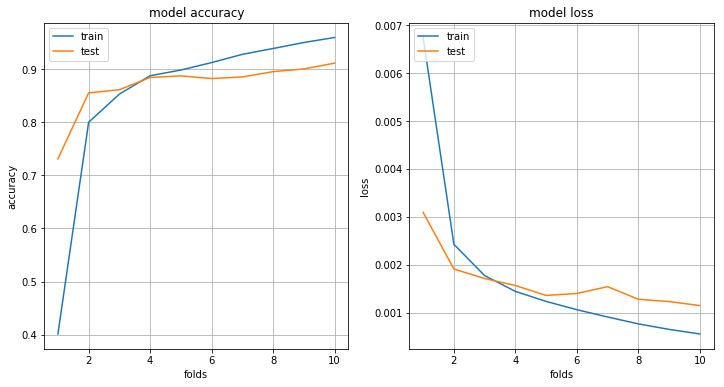

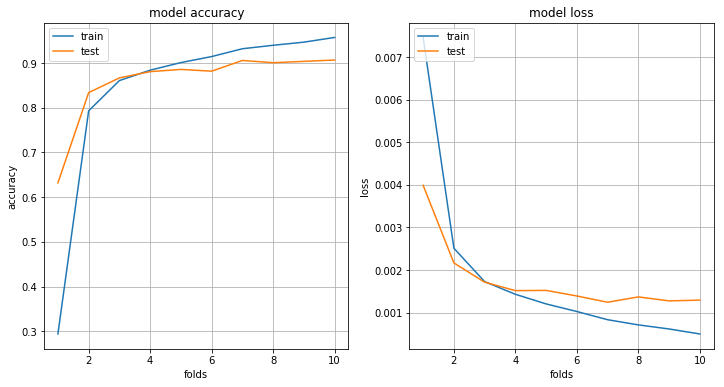

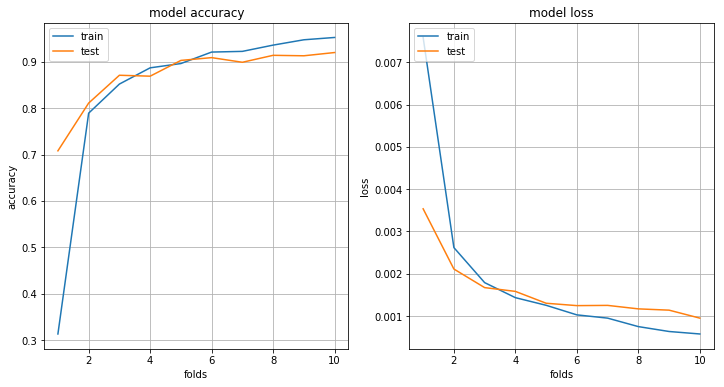

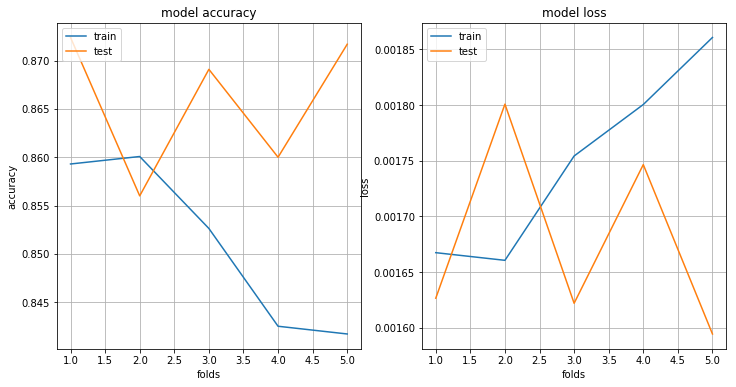

In [40]:
# Hyperparameters is composed of: hidden_units, learning_rate, batch size, and epochs (in this order)
hyperparameters = (50, 10, 10, 10)

cv_neural_network(hyperparameters)

##### Worst result
Let's evaluate the worst result now. It may happen because GD just evaluate the optimizer after all training, which can lead to poor results.

We can see signals of underfitting in all cases. Perphaps, with more epochs to train, we could achieve better results.

Starting evaluation at Fri May 18 18:47:37 2018...
CV 1: started at Fri May 18 18:47:37 2018, please wait...
CV 2: started at Fri May 18 18:47:50 2018, please wait...
CV 3: started at Fri May 18 18:48:02 2018, please wait...
CV 4: started at Fri May 18 18:48:14 2018, please wait...
CV 5: started at Fri May 18 18:48:26 2018, please wait...
Finished at Fri May 18 18:48:39 2018! Thank you for waiting.
Accuracy: 0.09889 (+/- 0.00000)
Loss: 0.00909 (+/- 0.00000)
Val. accuracy: 0.10291 (+/- 0.00000)
Val. loss: 0.00909 (+/- 0.00000)


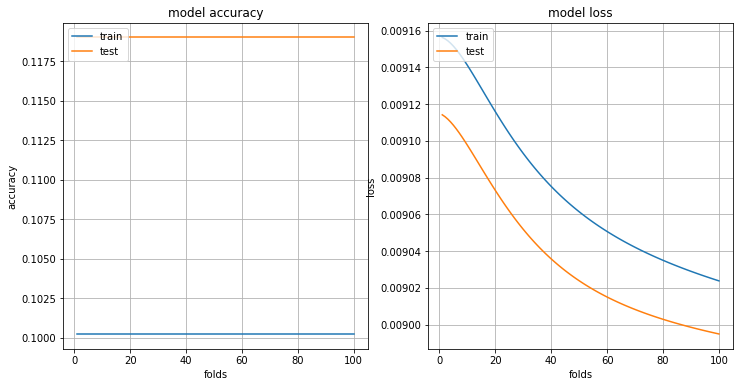

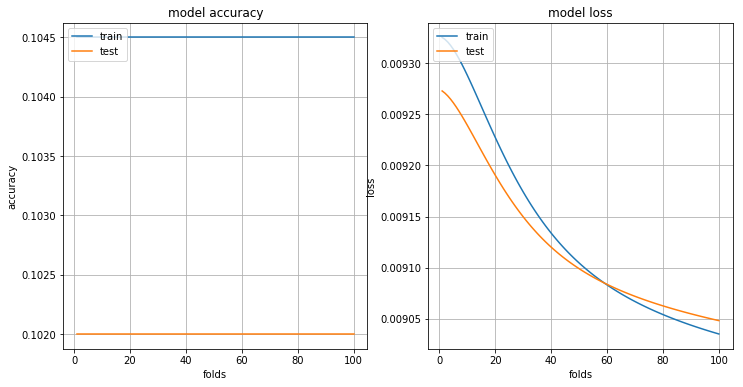

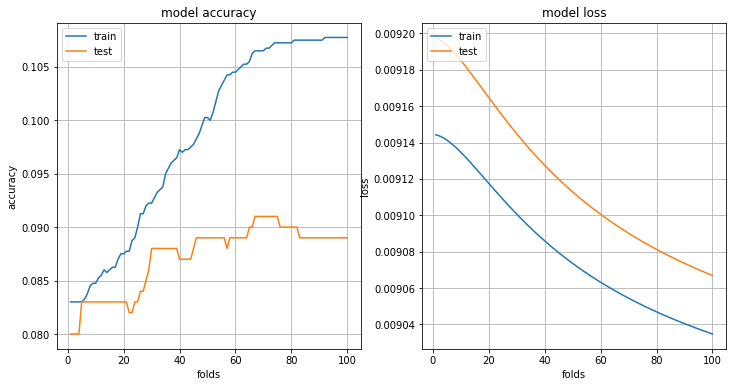

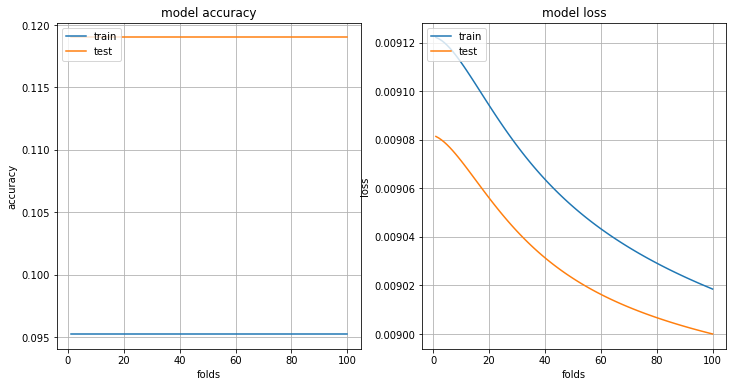

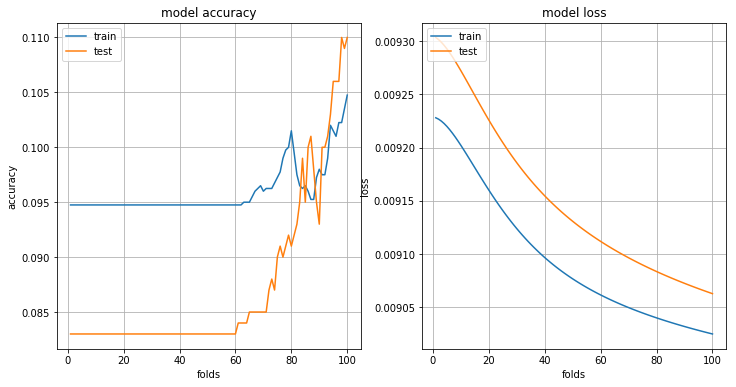

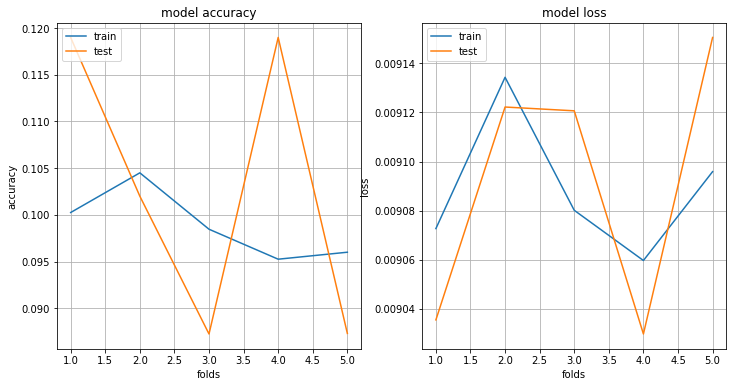

In [41]:
# Hyperparameters is composed of: hidden_units, learning_rate, batch size, and epochs (in this order)
hyperparameters = (25, 0.5, 4000, 100)

cv_neural_network(hyperparameters)

Starting evaluation at Fri May 18 18:48:57 2018...
CV 1: started at Fri May 18 18:48:57 2018, please wait...
CV 2: started at Fri May 18 18:49:13 2018, please wait...
CV 3: started at Fri May 18 18:49:30 2018, please wait...
CV 4: started at Fri May 18 18:49:46 2018, please wait...
CV 5: started at Fri May 18 18:50:02 2018, please wait...
Finished at Fri May 18 18:50:19 2018! Thank you for waiting.
Accuracy: 0.10030 (+/- 0.00000)
Loss: 0.00910 (+/- 0.00000)
Val. accuracy: 0.10320 (+/- 0.00000)
Val. loss: 0.00910 (+/- 0.00000)


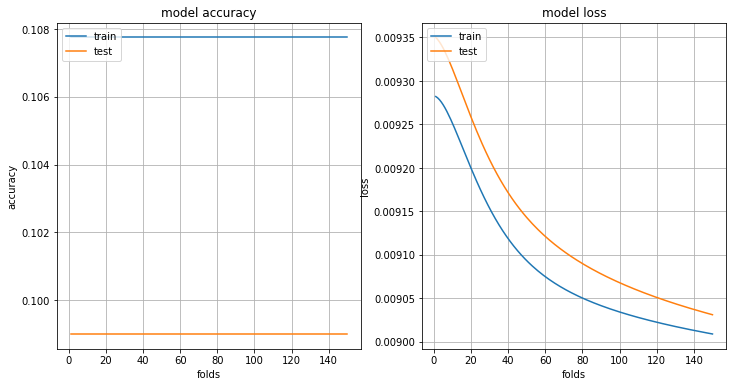

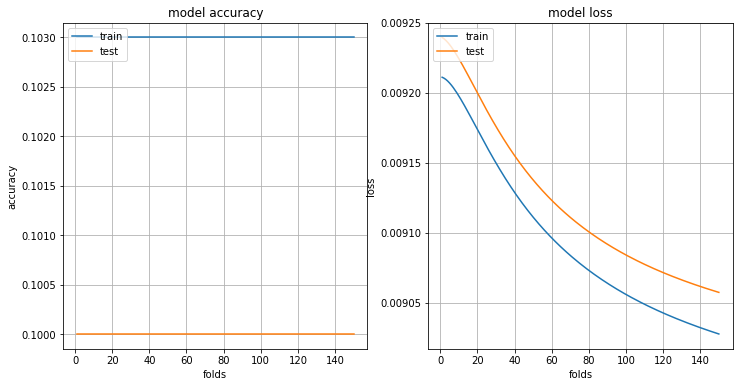

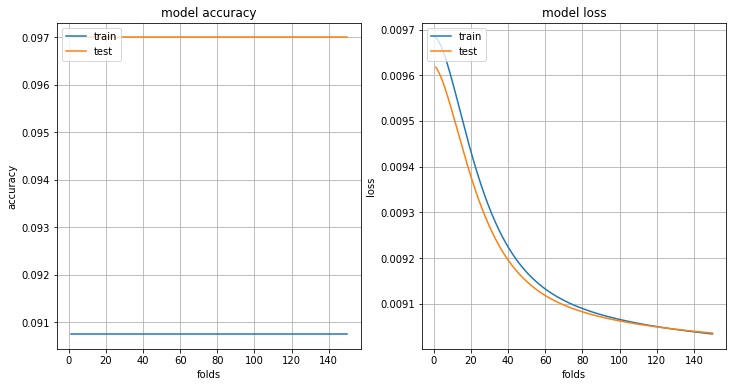

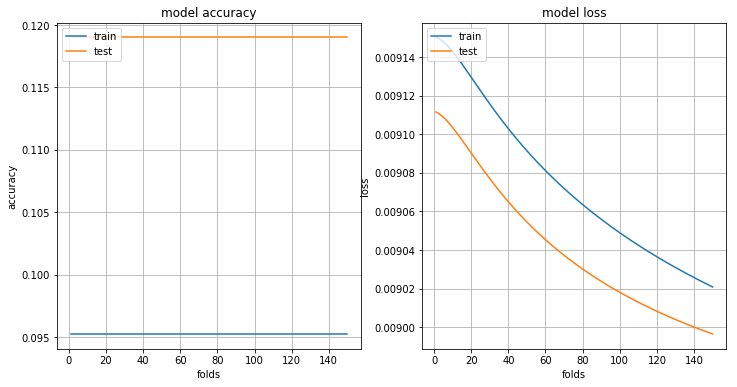

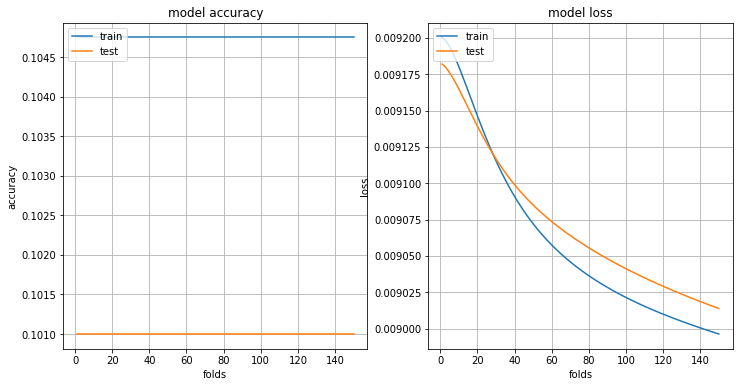

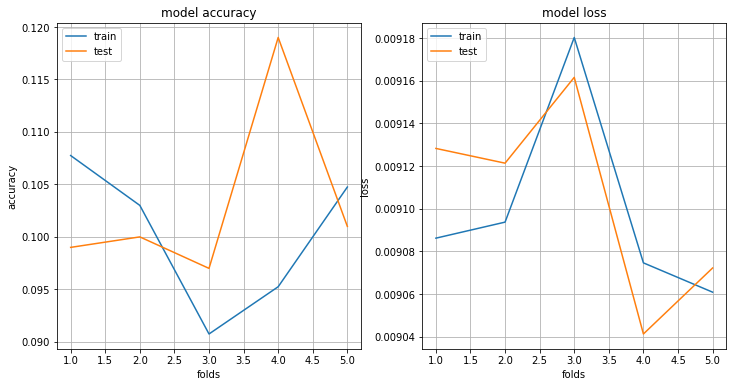

In [42]:
# Hyperparameters is composed of: hidden_units, learning_rate, batch size, and epochs (in this order)
hyperparameters = (25, 0.5, 4000, 150)

cv_neural_network(hyperparameters)

Starting evaluation at Fri May 18 18:50:48 2018...
CV 1: started at Fri May 18 18:50:48 2018, please wait...
CV 2: started at Fri May 18 18:50:57 2018, please wait...
CV 3: started at Fri May 18 18:51:05 2018, please wait...
CV 4: started at Fri May 18 18:51:14 2018, please wait...
CV 5: started at Fri May 18 18:51:22 2018, please wait...
Finished at Fri May 18 18:51:30 2018! Thank you for waiting.
Accuracy: 0.10429 (+/- 0.00000)
Loss: 0.00915 (+/- 0.00000)
Val. accuracy: 0.09894 (+/- 0.00000)
Val. loss: 0.00915 (+/- 0.00000)


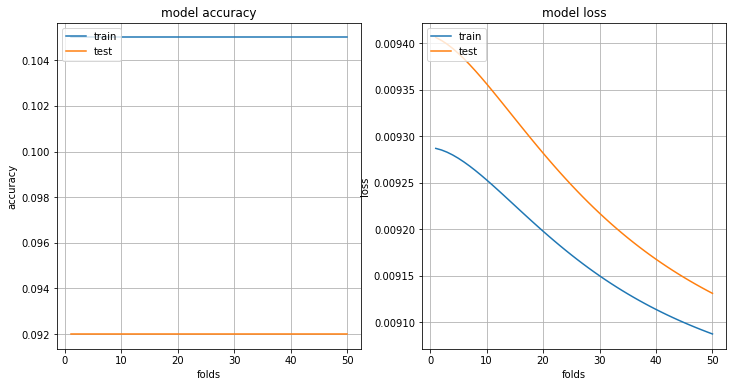

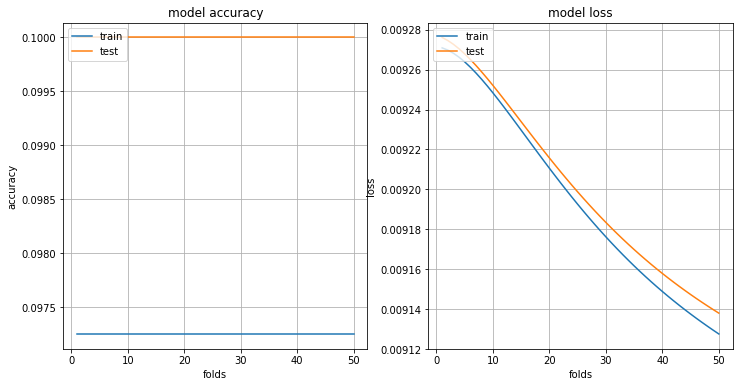

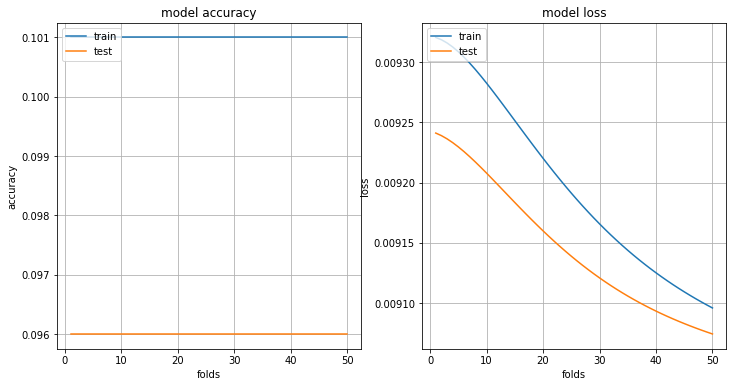

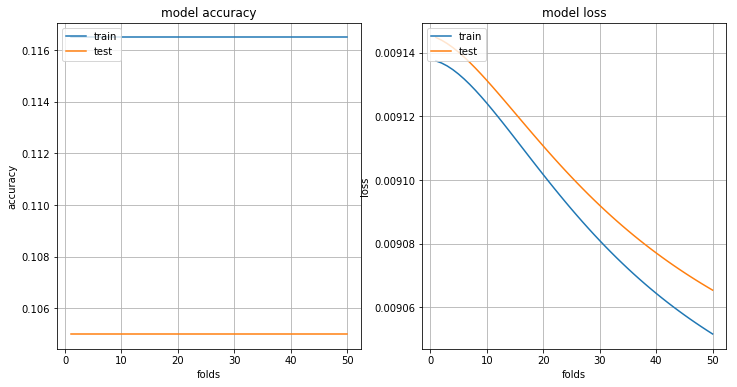

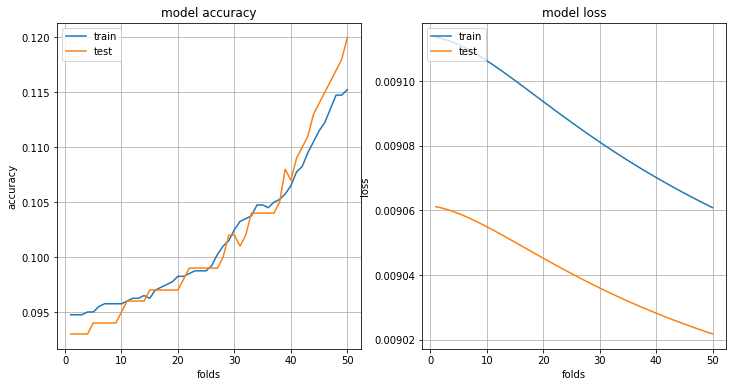

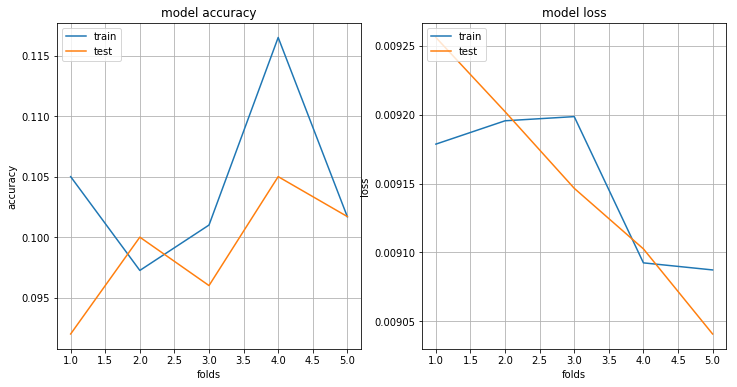

In [43]:
# Hyperparameters is composed of: hidden_units, learning_rate, batch size, and epochs (in this order)
hyperparameters = (25, 0.5, 4000, 50)

cv_neural_network(hyperparameters)